# Recommendation System Demo

In [1]:
import os
import importlib
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
import pickle

from utils import load_data, plot_age_distribution, plot_book_year_distribution, plot_rating_distribution
from personalization_index import *

## Dataset

In [2]:
items_df, users_df, ratings_df, all_ratings_df = load_data()

### User data

In [3]:
users_df.head()

,user_id,location,age,age_group
11,12,"fort bragg, california, usa",32.0,19-35
15,16,"albuquerque, new mexico, usa",32.0,19-35
25,26,"bellevue, washington, usa",32.0,19-35
31,32,"portland, oregon, usa",32.0,19-35
38,39,"cary, north carolina, usa",32.0,19-35


#### Age distribution

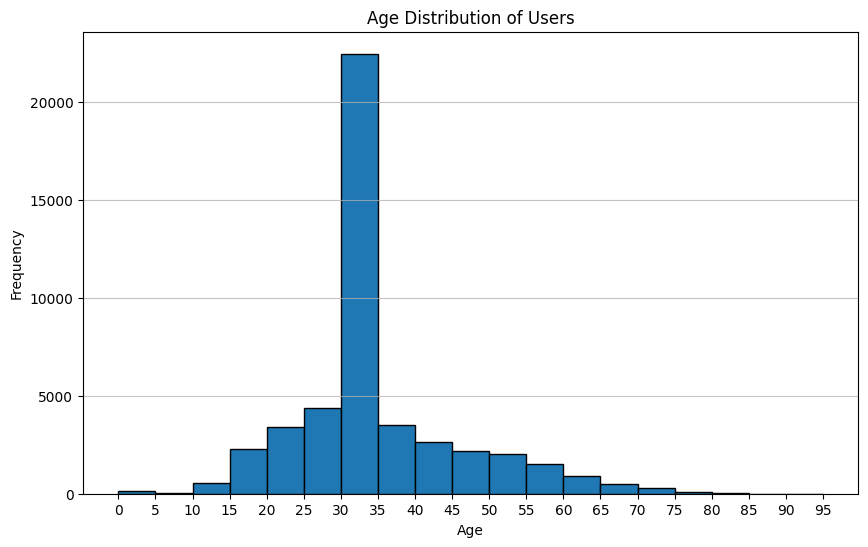

In [4]:
plot_age_distribution(users_df)

### Item data

In [5]:
items_df.head(5)

,item_id,title,author,Year-Of-Publication,publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...


#### Publish year distribution

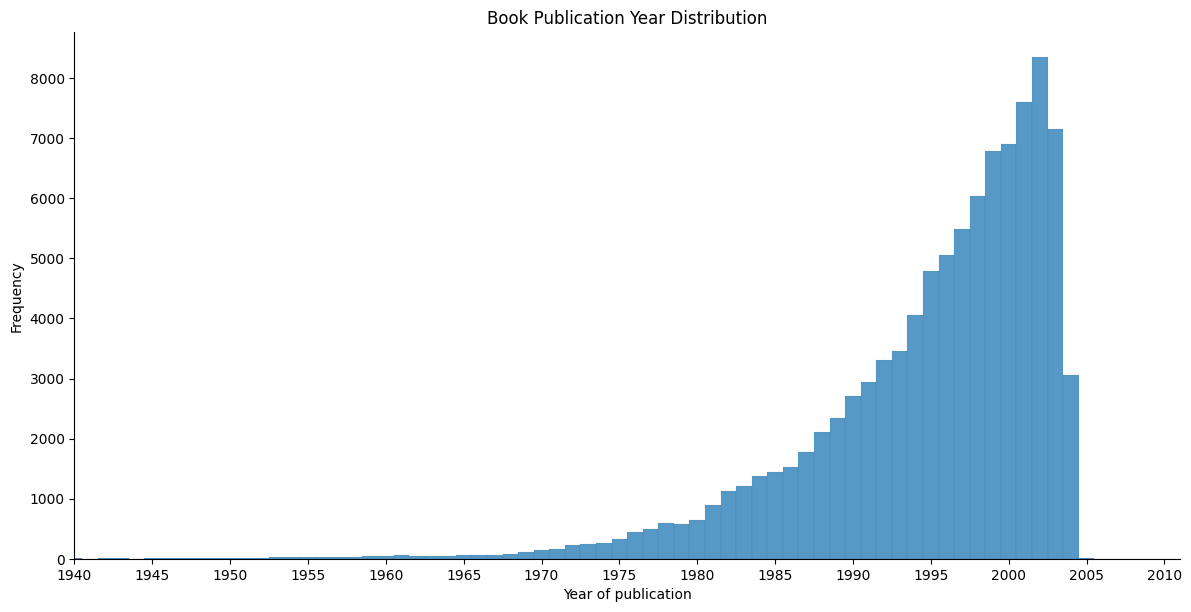

In [6]:
plot_book_year_distribution(items_df)

### Rating data

In [7]:
ratings_df.head(5)

,user_id,item_id,rating
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
27,276751,3596218098,8
28,276754,0684867621,8


#### Rating distribution

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


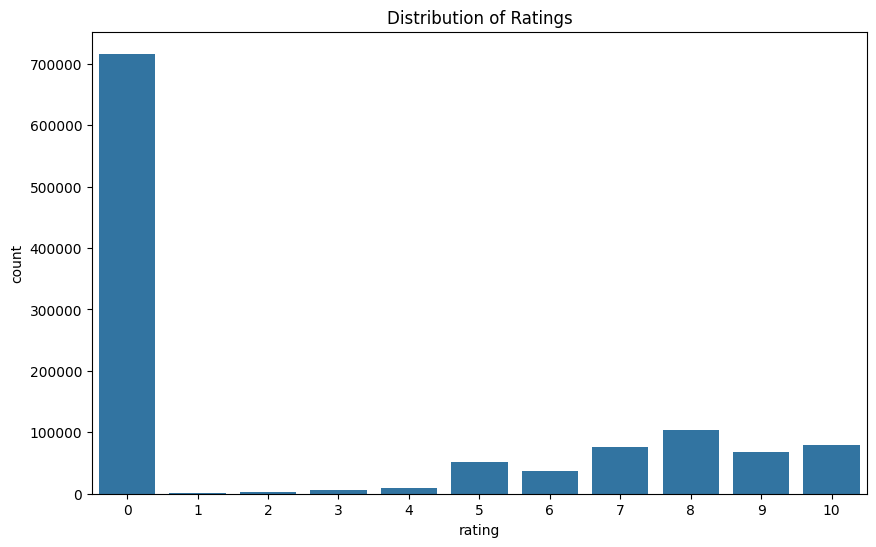

In [8]:
plot_rating_distribution(all_ratings_df)

#### User-item graph

## Engine Output

## Engine Performance Metrics

In [41]:
top_5_recommendations_df.columns = ['item1', 'item2', 'item3', 'item4', 'item5']
# turn index into user_idx column in top_5_recommendations_df
top_5_recommendations_df['user_idx'] = top_5_recommendations_df.index
top_5_recommendations_df.head()

,item1,item2,item3,item4,item5,user_idx
0,0,2,3,1,8,0
1,0,3,2,1,5,1
2,0,3,2,6,1,2
3,0,3,2,1,5,3
4,0,3,2,1,5,4


In [65]:
# merge top_5_recommendations_df with users_df, drop location_idx and age_group_idx

top_5_recommendations_users = pd.merge(top_5_recommendations_df, users_df[['user_id', 'user_idx']], on='user_idx', how='left')
top_5_recommendations_users.head()

,item1,item2,item3,item4,item5,user_idx,user_id
0,0,2,3,1,8,0,12
1,0,3,2,1,5,1,16
2,0,3,2,6,1,2,26
3,0,3,2,1,5,3,32
4,0,3,2,1,5,4,39


In [66]:
import pandas as pd

# Assuming top_5_recommendations_users is your initial DataFrame
# Columns 'item1' to 'item5' will be unpivoted into a single 'item' column
# The corresponding rank (1 to 5) will be in the 'rank' column

# First, create a dictionary to rename the 'item' columns to a 'rank'
rank_dict = {'item1': 1, 'item2': 2, 'item3': 3, 'item4': 4, 'item5': 5 }

# Use melt to reshape the DataFrame
long_format_df = top_5_recommendations_users.melt(id_vars=['user_idx', 'user_id'],
                                                  value_vars=list(rank_dict.keys()),
                                                  var_name='rank',
                                                  value_name='item')

# Replace the 'item1', 'item2', etc., with 1, 2, etc.
long_format_df['rank'] = long_format_df['rank'].map(rank_dict)

# Optionally, you might want to sort by user and rank
long_format_df = long_format_df.sort_values(by=['user_idx', 'rank'])
# rename "item" to "item_idx"
long_format_df.rename(columns={'item': 'item_idx'}, inplace=True)

# Reset index if needed
top_5_recommendations_long = long_format_df.reset_index(drop=True)
top_5_recommendations_long.head()
# The resulting DataFrame will have columns 'user_idx', 'user_id', 'location', 'age', 'age_group', 'rank', 'item'


,user_idx,user_id,rank,item_idx
0,0,12,1,0
1,0,12,2,2
2,0,12,3,3
3,0,12,4,1
4,0,12,5,8


In [67]:
# show the first 5 rows where rating less than 8 in ratings_df
all_ratings_df[all_ratings_df['rating'] < 8].head()

,user_id,item_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [73]:
### recommend items to individual users
items_df.columns

Index(['item_id', 'title', 'author', 'Year-Of-Publication', 'publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'item_idx', 'subject_idx',
       'author_idx'],
      dtype='object')

In [118]:
def recommend_items_to_user(user_id):
    """
    This function takes in a user id and returns a list of 5 recommended items for that user
    """
    # get all the rows of the user from ratings_df
    top_recommends = top_5_recommendations_long[top_5_recommendations_long['user_id'] == user_id]
    # merge with items_df to get all other item info
    top_recommends = pd.merge(top_recommends, items_df, on='item_idx', how='left')
     # all the title
    titles = top_recommends['title'].tolist()
    # exclude rows where rating less than 1 in all_ratings_df
    item_ratings = all_ratings_df[all_ratings_df['rating'] >= 0]

    # print the top 5 recommendations: {title} by {author} published in {Year-Of-Publication}
    print(f"Top 5 recommendations for user {user_id}:")
    for i in range(5):
        print(f"{i+1}. {top_recommends.iloc[i]['title']} by {top_recommends.iloc[i]['author']} published in {top_recommends.iloc[i]['Year-Of-Publication']}")
   
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, 5, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):        
        url = items_df.loc[items_df['title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = item_ratings.loc[item_ratings['item_id'] == items_df.loc[items_df['title'] == title]['item_id'][:1].values[0]]['rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

    # print the top 5 recommendations: {title} by {author} published in {Year-Of-Publication}
    # print a line of break
    print("----------------------------------------------------------------------------------------")
    print(f"Top favorite items for user {user_id}:")
    rating_history = item_ratings[item_ratings['user_id'] == user_id]
    top_history = rating_history.sort_values(by=['rating'], ascending=False)
    top_history = pd.merge(top_history, items_df, on='item_id', how='inner') 
    for i in range(len(top_history)):
        print(f"{i+1}. {top_history.iloc[i]['title']} by {top_history.iloc[i]['author']} published in {top_history.iloc[i]['Year-Of-Publication']}")
   

Top 5 recommendations for user 26:
1. Clara Callan by Richard Bruce Wright published in 2001
2. The Kitchen God's Wife by Amy Tan published in 1991
3. Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It by Gina Bari Kolata published in 1999
4. A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series) by Jack Canfield published in 1998
5. Decision in Normandy by Carlo D'Este published in 1991
----------------------------------------------------------------------------------------
Top favorite items for user 26:
1. To Kill a Mockingbird by Harper Lee published in 1988
2. Seabiscuit: An American Legend by LAURA HILLENBRAND published in 2002


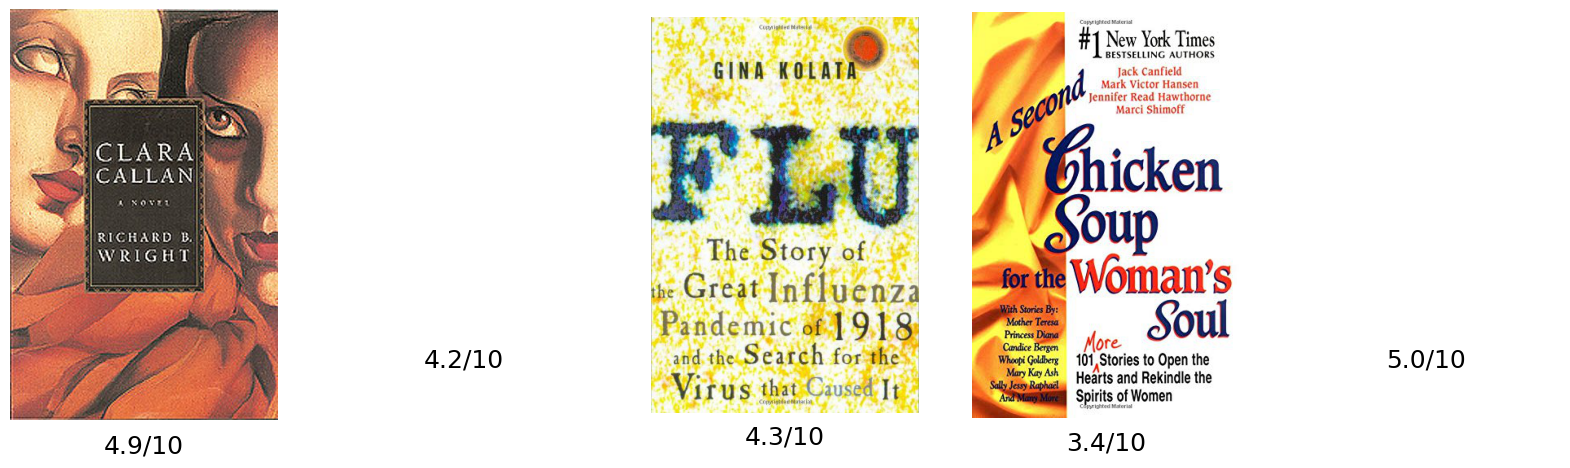

In [119]:
recommend_items_to_user(26)

Top 5 recommendations for user 32:
1. Clara Callan by Richard Bruce Wright published in 2001
2. The Kitchen God's Wife by Amy Tan published in 1991
3. Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It by Gina Bari Kolata published in 1999
4. Decision in Normandy by Carlo D'Este published in 1991
5. PLEADING GUILTY by Scott Turow published in 1993
----------------------------------------------------------------------------------------
Top favorite items for user 32:
1. Pigs in Heaven by Barbara Kingsolver published in 1993
2. Miss Zukas and the Raven's Dance by Jo Dereske published in 1996


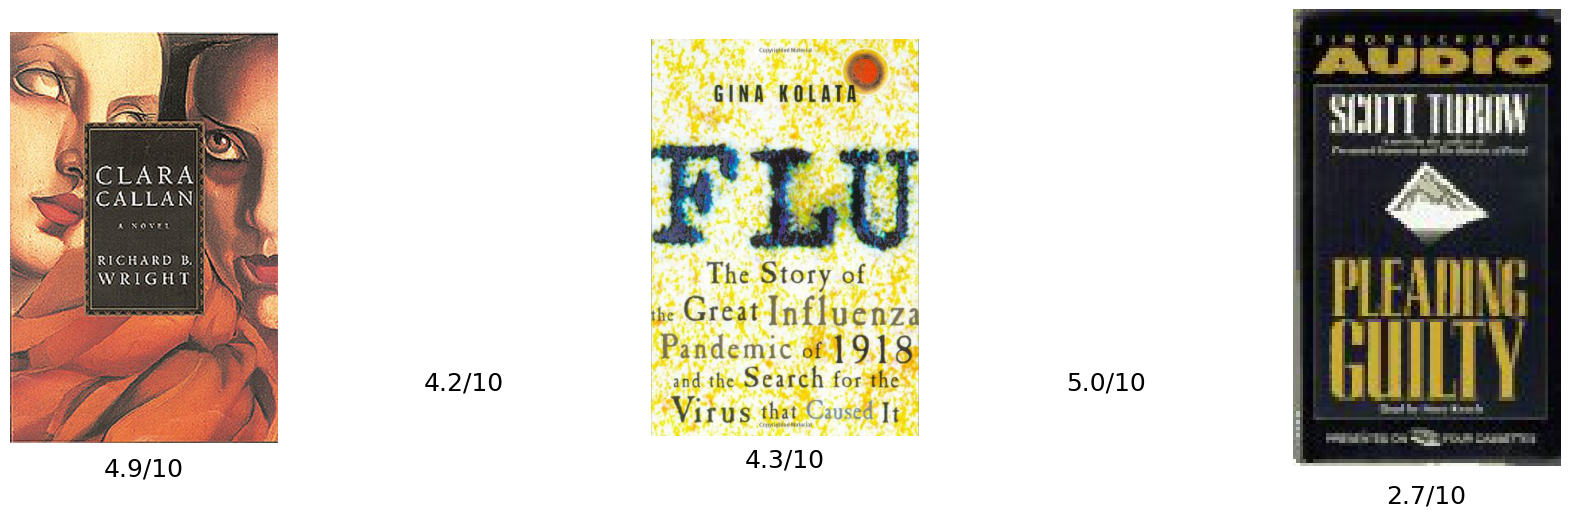

In [120]:
recommend_items_to_user(32)